<a href="https://colab.research.google.com/github/huyle3/competition_data/blob/main/PredictingWinVer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install catboost

In [2]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.naive_bayes import GaussianNB


In [3]:
#reading csv in
data_dict_url = "https://raw.githubusercontent.com/huyle3/competition_data/refs/heads/main/DataDictionary.csv"
data_dict_csv = pd.read_csv(data_dict_url)
east_regional_games_url = "https://raw.githubusercontent.com/huyle3/competition_data/refs/heads/main/East%20Regional%20Games%20to%20predict.csv"
east_regional_games_csv = pd.read_csv(east_regional_games_url)
team_regional_groups_url = "https://raw.githubusercontent.com/huyle3/competition_data/refs/heads/main/Team%20Region%20Groups.csv"
team_regional_groups_csv = pd.read_csv(team_regional_groups_url)
df_url = 'https://raw.githubusercontent.com/huyle3/competition_data/refs/heads/main/games_2022.csv'
df = pd.read_csv(df_url)

In [4]:
df['fg%'] = ((df['FGM_2'] + df['FGM_3']) / (df['FGA_2'] + df['FGA_3'])) * 100

In [5]:
print(df.shape)

(10438, 31)


In [6]:
df.head()

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,...,notD1_incomplete,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away,home_away_NS,travel_dist,fg%
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,50,22,11,5,6,3,14,...,False,NaN,9.0,3241.0,0.0,0.0,home,1,0.0,44.262295
1,game_2022_2011,2021-12-30,lsu_tigers,50,24,11,4,15,8,15,...,False,NaN,3.0,3241.0,0.0,824.0,away,-1,824.0,45.901639
2,game_2022_2012,2021-12-30,missouri_tigers,43,18,15,7,16,13,10,...,False,5.0,8.0,6139.0,0.0,371.0,home,1,0.0,43.103448
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,55,23,21,6,9,5,15,...,False,5.0,9.0,6139.0,0.0,1154.0,away,-1,1154.0,38.157895
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,41,20,15,4,15,10,16,...,False,NaN,3.0,8124.0,0.0,0.0,home,1,0.0,42.857143


Ranking Teams

Feature Creation

In [7]:
#2 pointer field goal percentage
df['fg_2%'] = (df['FGM_2'] / df['FGA_2']) * 100
# 3 pointer field goal percentage
df['fg_3%'] = (df['FGM_3'] /df['FGA_3']) * 100

In [8]:
df['fg_2%'].head()
df['fg_3%'].head()

,fg_3%
0,45.454545
1,36.363636
2,46.666667
3,28.571429
4,26.666667


In [9]:
df['AST_TO'] = df['AST'] / df['TOV']

In [10]:
# Compute each team's contribution to PIE
df["team_contribution"] = (
    df["team_score"] + df["FGM_2"] + df["FGM_3"] + df["FTM"]
    - df["FGA_2"] - df["FGA_3"] - df["FTA"] + df["DREB"]
    + (df["OREB"] / 2) + df["AST"] + df["STL"] + df["BLK"]
    - df["F_personal"] - df["TOV"]
)

# Merge with itself to get opponent contributions based on game_id
df = df.merge(df[["game_id", "team", "team_contribution"]],
              on="game_id",
              suffixes=("", "_opp"))

# Remove same-team matches (keep only opponent rows)
df = df[df["team"] != df["team_opp"]]

# Compute total game impact
df["game_total"] = df["team_contribution"] + df["team_contribution_opp"]

# Calculate PIE
df["PIE"] = df["team_contribution"] / df["game_total"]

# Drop extra columns
df = df.drop(columns=["team_opp", "team_contribution_opp"])

In [11]:
#Turnover ratio
df['TO%'] = (df['TOV'] * 100)/ ((df['FGA_2'] + df['FGA_3']) + (df['FTA'] * 0.44) + df['AST'] + df['TOV'])

In [12]:
#Effective field goal percentage
df['EFG%'] = (df['FGM_2'] + df['FGM_3'] + (1.5 * df['FGM_3'])) / (df['FGA_2'] + df['FGA_3'])

Create Target Var

In [13]:
#if team score is greater than opponent team score than they won
df['win'] = df.apply(lambda row: 1 if row['team_score'] > row['opponent_team_score'] else 0, axis=1)
df['win'].head()

,win
1,0
2,1
5,1
6,0
9,1


In [14]:
print(df.columns)

Index(['game_id', 'game_date', 'team', 'FGA_2', 'FGM_2', 'FGA_3', 'FGM_3',
       'FTA', 'FTM', 'AST', 'BLK', 'STL', 'TOV', 'TOV_team', 'DREB', 'OREB',
       'F_tech', 'F_personal', 'team_score', 'opponent_team_score',
       'largest_lead', 'notD1_incomplete', 'OT_length_min_tot', 'rest_days',
       'attendance', 'tz_dif_H_E', 'prev_game_dist', 'home_away',
       'home_away_NS', 'travel_dist', 'fg%', 'fg_2%', 'fg_3%', 'AST_TO',
       'team_contribution', 'game_total', 'PIE', 'TO%', 'EFG%', 'win'],
      dtype='object')


In [15]:
df_copy = df.copy()

In [20]:

# Assuming df is your DataFrame
numeric_cols = df_copy.select_dtypes(include=['number']).columns  # Get numeric column names

# Group by 'team' and compute the mean
team_averages = df_copy.groupby('team')[numeric_cols].mean().reset_index()

# Merge the averages back to the original DataFrame (optional)
df_with_team_avg = df_copy.merge(team_averages, on='team', suffixes=('', '_team_avg'))

In [21]:
df_with_team_avg.head()

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,...,fg%_team_avg,fg_2%_team_avg,fg_3%_team_avg,AST_TO_team_avg,team_contribution_team_avg,game_total_team_avg,PIE_team_avg,TO%_team_avg,EFG%_team_avg,win_team_avg
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,50,22,11,5,6,3,14,...,43.554598,46.119045,31.350559,1.127141,63.696429,99.250000,0.651156,15.794589,0.516279,0.678571
1,game_2022_2011,2021-12-30,lsu_tigers,50,24,11,4,15,8,15,...,44.849125,47.074160,34.484941,1.104665,67.089286,101.803571,0.677801,13.577417,0.530033,0.821429
2,game_2022_2012,2021-12-30,missouri_tigers,43,18,15,7,16,13,10,...,45.497361,49.523912,37.233360,0.971224,57.083333,105.683333,0.551445,16.233242,0.665830,0.600000
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,55,23,21,6,9,5,15,...,43.801675,47.652931,31.557827,1.087680,69.338710,90.822581,0.774249,14.874703,0.556041,0.935484
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,41,20,15,4,15,10,16,...,41.584983,45.145628,29.801121,0.911614,59.612903,92.951613,0.638571,16.713592,0.518172,0.741935


In [22]:
df_with_team_avg.drop(columns=numeric_cols, inplace=True)

In [23]:
df_with_team_avg.head()

,game_id,game_date,team,notD1_incomplete,home_away,FGA_2_team_avg,FGM_2_team_avg,FGA_3_team_avg,FGM_3_team_avg,FTA_team_avg,...,fg%_team_avg,fg_2%_team_avg,fg_3%_team_avg,AST_TO_team_avg,team_contribution_team_avg,game_total_team_avg,PIE_team_avg,TO%_team_avg,EFG%_team_avg,win_team_avg
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,False,home,51.928571,23.928571,10.678571,3.357143,15.357143,...,43.554598,46.119045,31.350559,1.127141,63.696429,99.250000,0.651156,15.794589,0.516279,0.678571
1,game_2022_2011,2021-12-30,lsu_tigers,False,away,53.821429,25.250000,10.178571,3.428571,19.642857,...,44.849125,47.074160,34.484941,1.104665,67.089286,101.803571,0.677801,13.577417,0.530033,0.821429
2,game_2022_2012,2021-12-30,missouri_tigers,False,home,35.533333,17.433333,20.766667,8.000000,15.633333,...,45.497361,49.523912,37.233360,0.971224,57.083333,105.683333,0.551445,16.233242,0.665830,0.600000
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,False,away,46.451613,21.967742,15.096774,4.774194,19.419355,...,43.801675,47.652931,31.557827,1.087680,69.338710,90.822581,0.774249,14.874703,0.556041,0.935484
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,False,home,49.129032,22.032258,14.451613,4.387097,19.838710,...,41.584983,45.145628,29.801121,0.911614,59.612903,92.951613,0.638571,16.713592,0.518172,0.741935


In [15]:

# Compute past statistics
def compute_past_stats(df):
    df['total_games_before'] = df.groupby('team').cumcount()  # Games before current one
    df['total_wins_before'] = df.groupby('team')['win'].cumsum().shift(1).fillna(0)  # Wins before
    df['win_pct_before'] = df['total_wins_before'] / df['total_games_before'].replace(0, 1)  # Avoid divide by zero
    df['total_points_before'] = df.groupby('team')['team_score'].cumsum().shift(1).fillna(0)  # Points before
    df['avg_ppg_before'] = df['total_points_before'] / df['total_games_before'].replace(0, 1)

    df['last5_wins'] = df.groupby('team')['win'].rolling(window=5, min_periods=1).sum().shift(1).reset_index(level=0, drop=True)

    # Compute rolling averages for all numeric columns except identifiers
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    exclude_cols = ['game_id','team', 'game_date', 'win', 'team_score', 'opponent_team', 'total_games_before', 'total_wins_before', 'win_pct_before', 'total_points_before', 'avg_ppg_before', 'last5_wins', 'team_elo_before']

    for col in numeric_cols:
        if col not in exclude_cols:
            df[f'avg_{col}_before'] = df.groupby('team')[col].expanding().mean().shift(1).reset_index(level=0, drop=True)

    return df

# Apply rolling statistics function
df_new = compute_past_stats(df)


# Final sorting before merging teams
df_new = df_new.sort_values(['game_date', 'game_id', 'team']).reset_index(drop=True)

# Final DataFrame with Elo ratings and past stats
df_new.head()

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,...,avg_travel_dist_before,avg_fg%_before,avg_fg_2%_before,avg_fg_3%_before,avg_AST_TO_before,avg_team_contribution_before,avg_game_total_before,avg_PIE_before,avg_TO%_before,avg_EFG%_before
0,game_2022_1,2021-11-09,texas_am_aggies,39,18,24,12,28,15,23,...,562.666667,37.679590,39.935901,32.113157,0.857453,39.166667,103.166667,0.375720,15.850476,0.507918
1,game_2022_1,2021-11-09,texas_am_corpus_christi_islanders,57,21,13,0,22,12,12,...,693.000000,41.155901,42.988929,36.617544,1.026012,51.568966,99.327586,0.533661,15.476259,0.566753
2,game_2022_10,2021-11-09,james_madison_dukes,51,24,14,5,29,21,3,...,196.000000,39.844514,42.695739,34.068779,0.728438,47.968750,90.625000,0.532731,16.642260,0.557600
3,game_2022_10,2021-11-09,virginia_cavaliers,48,25,15,1,28,16,15,...,275.666667,40.520426,46.968104,30.443077,1.429185,56.600000,99.933333,0.570734,13.845411,0.591466
4,game_2022_100,2021-11-09,charlotte_49ers,55,21,15,3,15,12,13,...,376.333333,34.474467,37.945672,27.122854,0.849376,26.416667,93.916667,0.250241,17.408363,0.479131


In [16]:
df_new.head()

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,...,avg_travel_dist_before,avg_fg%_before,avg_fg_2%_before,avg_fg_3%_before,avg_AST_TO_before,avg_team_contribution_before,avg_game_total_before,avg_PIE_before,avg_TO%_before,avg_EFG%_before
0,game_2022_1,2021-11-09,texas_am_aggies,39,18,24,12,28,15,23,...,562.666667,37.679590,39.935901,32.113157,0.857453,39.166667,103.166667,0.375720,15.850476,0.507918
1,game_2022_1,2021-11-09,texas_am_corpus_christi_islanders,57,21,13,0,22,12,12,...,693.000000,41.155901,42.988929,36.617544,1.026012,51.568966,99.327586,0.533661,15.476259,0.566753
2,game_2022_10,2021-11-09,james_madison_dukes,51,24,14,5,29,21,3,...,196.000000,39.844514,42.695739,34.068779,0.728438,47.968750,90.625000,0.532731,16.642260,0.557600
3,game_2022_10,2021-11-09,virginia_cavaliers,48,25,15,1,28,16,15,...,275.666667,40.520426,46.968104,30.443077,1.429185,56.600000,99.933333,0.570734,13.845411,0.591466
4,game_2022_100,2021-11-09,charlotte_49ers,55,21,15,3,15,12,13,...,376.333333,34.474467,37.945672,27.122854,0.849376,26.416667,93.916667,0.250241,17.408363,0.479131


In [17]:
print(df_new.columns)

Index(['game_id', 'game_date', 'team', 'FGA_2', 'FGM_2', 'FGA_3', 'FGM_3',
       'FTA', 'FTM', 'AST', 'BLK', 'STL', 'TOV', 'TOV_team', 'DREB', 'OREB',
       'F_tech', 'F_personal', 'team_score', 'opponent_team_score',
       'largest_lead', 'notD1_incomplete', 'OT_length_min_tot', 'rest_days',
       'attendance', 'tz_dif_H_E', 'prev_game_dist', 'home_away',
       'home_away_NS', 'travel_dist', 'fg%', 'fg_2%', 'fg_3%', 'AST_TO',
       'team_contribution', 'game_total', 'PIE', 'TO%', 'EFG%', 'win',
       'total_games_before', 'total_wins_before', 'win_pct_before',
       'total_points_before', 'avg_ppg_before', 'last5_wins',
       'avg_FGA_2_before', 'avg_FGM_2_before', 'avg_FGA_3_before',
       'avg_FGM_3_before', 'avg_FTA_before', 'avg_FTM_before',
       'avg_AST_before', 'avg_BLK_before', 'avg_STL_before', 'avg_TOV_before',
       'avg_TOV_team_before', 'avg_DREB_before', 'avg_OREB_before',
       'avg_F_tech_before', 'avg_F_personal_before',
       'avg_opponent_team_score_b

In [18]:
columns_drop = ['FGA_2', 'FGM_2', 'FGA_3', 'FGM_3',
       'FTA', 'FTM', 'AST', 'BLK', 'STL', 'TOV', 'TOV_team', 'DREB', 'OREB',
       'F_tech', 'F_personal', 'team_score', 'opponent_team_score',
       'largest_lead', 'notD1_incomplete', 'OT_length_min_tot', 'rest_days',
       'attendance', 'tz_dif_H_E', 'prev_game_dist', 'home_away',
       'home_away_NS', 'travel_dist', 'fg%', 'fg_2%', 'fg_3%', 'AST_TO',
       'team_contribution', 'game_total', 'PIE', 'TO%', 'EFG%']
df_new.drop(columns=columns_drop, inplace=True)

In [19]:
# columns_drop = [
#        'F_tech', 'F_personal', 'team_score', 'opponent_team_score',
#        'largest_lead', 'notD1_incomplete', 'OT_length_min_tot',
#        'attendance', 'tz_dif_H_E', 'prev_game_dist', 'home_away',
#        'home_away_NS', 'travel_dist', 'fg%', 'fg_2%', 'fg_3%', 'AST_TO',
#        'team_contribution', 'game_total', 'PIE', 'TO%', 'EFG%']
# df_new.drop(columns=columns_drop, inplace=True)

In [20]:
# Drop the first game for each team
df_new = df_new.groupby('team').apply(lambda group: group.iloc[1:]).reset_index(drop=True)

In [21]:
print(df_new.isnull().sum())

game_id                              0
game_date                            0
team                                 0
win                                  0
total_games_before                   0
total_wins_before                    0
win_pct_before                       0
total_points_before                  0
avg_ppg_before                       0
last5_wins                           1
avg_FGA_2_before                     1
avg_FGM_2_before                     1
avg_FGA_3_before                     1
avg_FGM_3_before                     1
avg_FTA_before                       1
avg_FTM_before                       1
avg_AST_before                       1
avg_BLK_before                       1
avg_STL_before                       1
avg_TOV_before                       1
avg_TOV_team_before                  1
avg_DREB_before                      1
avg_OREB_before                      1
avg_F_tech_before                    1
avg_F_personal_before                1
avg_opponent_team_score_b

In [22]:
print(df_new.columns)

Index(['game_id', 'game_date', 'team', 'win', 'total_games_before',
       'total_wins_before', 'win_pct_before', 'total_points_before',
       'avg_ppg_before', 'last5_wins', 'avg_FGA_2_before', 'avg_FGM_2_before',
       'avg_FGA_3_before', 'avg_FGM_3_before', 'avg_FTA_before',
       'avg_FTM_before', 'avg_AST_before', 'avg_BLK_before', 'avg_STL_before',
       'avg_TOV_before', 'avg_TOV_team_before', 'avg_DREB_before',
       'avg_OREB_before', 'avg_F_tech_before', 'avg_F_personal_before',
       'avg_opponent_team_score_before', 'avg_largest_lead_before',
       'avg_OT_length_min_tot_before', 'avg_rest_days_before',
       'avg_attendance_before', 'avg_tz_dif_H_E_before',
       'avg_prev_game_dist_before', 'avg_home_away_NS_before',
       'avg_travel_dist_before', 'avg_fg%_before', 'avg_fg_2%_before',
       'avg_fg_3%_before', 'avg_AST_TO_before', 'avg_team_contribution_before',
       'avg_game_total_before', 'avg_PIE_before', 'avg_TO%_before',
       'avg_EFG%_before'],
    

In [23]:
# selected_features = [
#     'game_id', 'team', 'game_date', 'win', 'win_pct_before', 'last5_wins', 'avg_AST_before',
#     'avg_BLK_before', 'avg_STL_before', 'avg_TOV_before', 'avg_DREB_before', 'avg_OREB_before',
#     'avg_largest_lead_before', 'avg_AST_TO_before', 'avg_PIE_before', 'avg_TO%_before',
#     'avg_EFG%_before', 'avg_OT_length_min_tot_before', 'avg_fg%_before' , 'avg_fg_2%_before',
#     'avg_fg_3%_before', 'avg_game_total_before', 'team_elo_before'
# ]
# df_selected = df_new[selected_features]

In [24]:
selected_features = [
   'game_id', 'team', 'game_date', 'win',
       'total_games_before', 'total_wins_before', 'win_pct_before',
       'total_points_before', 'avg_ppg_before', 'last5_wins',
       'avg_FGA_2_before', 'avg_FGM_2_before', 'avg_FGA_3_before',
       'avg_FGM_3_before', 'avg_FTA_before', 'avg_FTM_before',
       'avg_AST_before', 'avg_BLK_before', 'avg_STL_before', 'avg_TOV_before',
       'avg_TOV_team_before', 'avg_DREB_before', 'avg_OREB_before',
       'avg_F_tech_before', 'avg_F_personal_before',
       'avg_opponent_team_score_before', 'avg_largest_lead_before',
       'avg_OT_length_min_tot_before', 'avg_rest_days_before',
       'avg_attendance_before', 'avg_tz_dif_H_E_before',
       'avg_prev_game_dist_before', 'avg_home_away_NS_before',
       'avg_travel_dist_before', 'avg_fg%_before', 'avg_fg_2%_before',
       'avg_fg_3%_before', 'avg_AST_TO_before', 'avg_team_contribution_before',
       'avg_game_total_before', 'avg_PIE_before', 'avg_TO%_before',
       'avg_EFG%_before'
]
df_selected = df_new[selected_features]

In [25]:
# Sort by game_id to ensure consistent order
df_selected = df_selected.sort_values(by=["game_id", "team"])

# Create two separate DataFrames for each team in the game
df_team1 = df_selected.groupby("game_id").nth(0).reset_index()
df_team2 = df_selected.groupby("game_id").nth(1).reset_index()

# Rename columns to differentiate team1 and team2
df_team1 = df_team1.add_prefix("team1_")
df_team2 = df_team2.add_prefix("team2_")

# Fix column names (game_id shouldn't be prefixed)
df_team1.rename(columns={"team1_game_id": "game_id"}, inplace=True)
df_team2.rename(columns={"team2_game_id": "game_id"}, inplace=True)

# Merge team1 and team2 stats on game_id
df_merged = pd.merge(df_team1, df_team2, on="game_id")

# Create target variable: 1 if team1 won, 0 if team2 won
df_merged["team1_win"] = (df_merged["team1_win"] == 1).astype(int)

# List of features to compute differences for
features_to_diff = [
       'total_games_before', 'total_wins_before', 'win_pct_before',
       'total_points_before', 'avg_ppg_before', 'last5_wins',
       'avg_FGA_2_before', 'avg_FGM_2_before', 'avg_FGA_3_before',
       'avg_FGM_3_before', 'avg_FTA_before', 'avg_FTM_before',
       'avg_AST_before', 'avg_BLK_before', 'avg_STL_before', 'avg_TOV_before',
       'avg_TOV_team_before', 'avg_DREB_before', 'avg_OREB_before',
       'avg_F_tech_before', 'avg_F_personal_before',
       'avg_opponent_team_score_before', 'avg_largest_lead_before',
       'avg_OT_length_min_tot_before', 'avg_rest_days_before',
       'avg_attendance_before', 'avg_tz_dif_H_E_before',
       'avg_prev_game_dist_before', 'avg_home_away_NS_before',
       'avg_travel_dist_before', 'avg_fg%_before', 'avg_fg_2%_before',
       'avg_fg_3%_before', 'avg_AST_TO_before', 'avg_team_contribution_before',
       'avg_game_total_before', 'avg_PIE_before', 'avg_TO%_before',
       'avg_EFG%_before']  # Modify as needed

# Create difference features
for feature in features_to_diff:
    df_merged[f"{feature}_diff"] = df_merged[f"team1_{feature}"] - df_merged[f"team2_{feature}"]

# Drop original team1 and team2 columns (except necessary ones like game_id, team1_win)
columns_to_drop = [f"team1_{feature}" for feature in features_to_diff] + [f"team2_{feature}" for feature in features_to_diff]
df_merged.drop(columns=columns_to_drop + ["team1_game_date", "team2_game_date"], inplace=True)


In [26]:
print(df_merged.shape)

(4841, 46)


In [27]:
df_merged.head()

,team1_index,game_id,team1_team,team1_win,team2_index,team2_team,team2_win,total_games_before_diff,total_wins_before_diff,win_pct_before_diff,...,avg_travel_dist_before_diff,avg_fg%_before_diff,avg_fg_2%_before_diff,avg_fg_3%_before_diff,avg_AST_TO_before_diff,avg_team_contribution_before_diff,avg_game_total_before_diff,avg_PIE_before_diff,avg_TO%_before_diff,avg_EFG%_before_diff
0,829,game_2022_1000,bucknell_bison,1,5483,north_dakota_fighting_hawks,0,-16,3.0,0.915385,...,-372.583333,-1.692487,-2.012392,-0.879402,0.013225,-10.023077,-22.115385,-0.005669,0.458448,-0.006662
1,1651,game_2022_1001,creighton_bluejays,1,5709,northern_iowa_panthers,0,-10,9.0,0.977273,...,-229.969697,1.031355,-0.141489,4.203442,0.790555,2.314394,15.268939,-0.082068,-0.794969,0.079627
2,7941,game_2022_1002,temple_owls,1,9239,villanova_wildcats,0,-2,5.0,0.287785,...,323.979296,-2.139162,-3.555398,-7.716191,-0.638373,-14.772257,-15.910973,-0.074614,5.381443,-0.105753
3,2093,game_2022_1003,eastern_kentucky_colonels,0,9795,xavier_musketeers,1,-4,-2.0,-0.019048,...,-107.360000,-0.455831,0.286013,3.204483,-0.178800,1.578095,-16.293333,0.104531,1.141138,0.058197
4,3208,game_2022_1004,illinois_fighting_illini,0,4662,middle_tennessee_blue_raiders,1,-8,17.0,0.972710,...,-181.060429,-1.435774,-3.856582,-3.345996,-0.264900,-9.419103,22.559454,-0.209544,2.360874,-0.113346


In [28]:
print(df_merged.isnull().sum())

team1_index                               0
game_id                                   0
team1_team                                0
team1_win                                 0
team2_index                               0
team2_team                                0
team2_win                                 0
total_games_before_diff                   0
total_wins_before_diff                    0
win_pct_before_diff                       0
total_points_before_diff                  0
avg_ppg_before_diff                       0
last5_wins_diff                           1
avg_FGA_2_before_diff                     1
avg_FGM_2_before_diff                     1
avg_FGA_3_before_diff                     1
avg_FGM_3_before_diff                     1
avg_FTA_before_diff                       1
avg_FTM_before_diff                       1
avg_AST_before_diff                       1
avg_BLK_before_diff                       1
avg_STL_before_diff                       1
avg_TOV_before_diff             

In [29]:
print(df_merged.dtypes)

team1_index                              int64
game_id                                 object
team1_team                              object
team1_win                                int64
team2_index                              int64
team2_team                              object
team2_win                                int64
total_games_before_diff                  int64
total_wins_before_diff                 float64
win_pct_before_diff                    float64
total_points_before_diff               float64
avg_ppg_before_diff                    float64
last5_wins_diff                        float64
avg_FGA_2_before_diff                  float64
avg_FGM_2_before_diff                  float64
avg_FGA_3_before_diff                  float64
avg_FGM_3_before_diff                  float64
avg_FTA_before_diff                    float64
avg_FTM_before_diff                    float64
avg_AST_before_diff                    float64
avg_BLK_before_diff                    float64
avg_STL_befor

In [30]:

df_merged.drop(4764, inplace=True)
# One game was corrupt for some reason, just deleted it

Data preprocessing

In [31]:
print(df_merged.dtypes)

team1_index                              int64
game_id                                 object
team1_team                              object
team1_win                                int64
team2_index                              int64
team2_team                              object
team2_win                                int64
total_games_before_diff                  int64
total_wins_before_diff                 float64
win_pct_before_diff                    float64
total_points_before_diff               float64
avg_ppg_before_diff                    float64
last5_wins_diff                        float64
avg_FGA_2_before_diff                  float64
avg_FGM_2_before_diff                  float64
avg_FGA_3_before_diff                  float64
avg_FGM_3_before_diff                  float64
avg_FTA_before_diff                    float64
avg_FTM_before_diff                    float64
avg_AST_before_diff                    float64
avg_BLK_before_diff                    float64
avg_STL_befor

In [32]:
print(df_merged.isnull().sum())

team1_index                               0
game_id                                   0
team1_team                                0
team1_win                                 0
team2_index                               0
team2_team                                0
team2_win                                 0
total_games_before_diff                   0
total_wins_before_diff                    0
win_pct_before_diff                       0
total_points_before_diff                  0
avg_ppg_before_diff                       0
last5_wins_diff                           1
avg_FGA_2_before_diff                     1
avg_FGM_2_before_diff                     1
avg_FGA_3_before_diff                     1
avg_FGM_3_before_diff                     1
avg_FTA_before_diff                       1
avg_FTM_before_diff                       1
avg_AST_before_diff                       1
avg_BLK_before_diff                       1
avg_STL_before_diff                       1
avg_TOV_before_diff             

In [33]:
df_merged.to_csv("data_after_diff.csv", index=False)

In [37]:
df_merged.drop(761, inplace=True)


In [34]:
#drop unneeded columns
column_drop = ['team2_win', 'team2_index', 'team2_team', 'team1_team', 'game_id', 'team1_index', 'avg_OT_length_min_tot_before_diff', "avg_rest_days_before_diff", "avg_attendance_before_diff", "avg_tz_dif_H_E_before_diff", "avg_prev_game_dist_before_diff", "avg_travel_dist_before_diff"]
df_merged.drop(columns=column_drop, inplace=True)

In [38]:
print(df_merged.isnull().sum())

team1_win                              0
total_games_before_diff                0
total_wins_before_diff                 0
win_pct_before_diff                    0
total_points_before_diff               0
avg_ppg_before_diff                    0
last5_wins_diff                        0
avg_FGA_2_before_diff                  0
avg_FGM_2_before_diff                  0
avg_FGA_3_before_diff                  0
avg_FGM_3_before_diff                  0
avg_FTA_before_diff                    0
avg_FTM_before_diff                    0
avg_AST_before_diff                    0
avg_BLK_before_diff                    0
avg_STL_before_diff                    0
avg_TOV_before_diff                    0
avg_TOV_team_before_diff               0
avg_DREB_before_diff                   0
avg_OREB_before_diff                   0
avg_F_tech_before_diff                 0
avg_F_personal_before_diff             0
avg_opponent_team_score_before_diff    0
avg_largest_lead_before_diff           0
avg_home_away_NS

In [39]:
X = df_merged.drop(columns='team1_win')
y = df_merged['team1_win']

In [44]:
print(X.shape)

(4839, 33)


In [55]:
df_merged.to_csv("data_after_diff_new.csv", index=False)

In [48]:
X = df_merged.drop(columns='team1_win')
y = df_merged['team1_win']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.16, random_state=1)

Normalization

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

Log loss on

In [38]:
# # Standard Libraries
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import log_loss

# # Model Selection & Evaluation
# from sklearn.model_selection import StratifiedKFold, cross_val_score

# # Machine Learning Models
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# losses= {}
# models = {
#     "Logistic Regression": LogisticRegression(),
#     "Random Forest": RandomForestClassifier(n_estimators=100),
#     "Gradient Boosting": GradientBoostingClassifier(),
#     "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
#     "LightGBM": LGBMClassifier(),
#     "CatBoost": CatBoostClassifier(verbose=0),
#     "SVM": SVC()
# }
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [3, 6, 10],
#     'subsample': [0.8, 1.0],
# }




# for name, model in models.items():
#   print(f"Training {name}...")

#   log_loss_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_log_loss')

#   losses[name] = -log_loss_scores
#   print(f"Mean Log-Loss for {name}: {np.mean(losses[name]):.4f}")
# for name, loss in losses.items():
#   plt.plot(range(1, len(loss)+1), loss, label=name)
# # Add labels and title
# plt.xlabel('Fold')
# plt.ylabel('Log-Loss (Cross-Entropy Loss)')
# plt.title('Model Log-Loss (Cross-Entropy Loss) Across Cross-Validation Folds')
# plt.legend(title='Models')

# # Show the plot
# plt.show()

In [51]:
# Standard Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV

# Model Selection & Evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "SVM": SVC()
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
}


for name, model in models.items():
  print(f"Training {name}...")

  scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

  results[name] = np.mean(scores)

results_df = pd.DataFrame(results.items(), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\nModel Performance with Stratified CV:")
print(results_df)

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 1971, number of negative: 1900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7757
[LightGBM] [Info] Number of data points in the train set: 3871, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509171 -> initscore=0.036687
[LightGBM] [Info] Start training from score 0.036687
[LightGBM] [Info] Number of positive: 1971, number of negative: 1900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7751
[LightGBM] [Info] Number of data points in the train set: 3871, number of used features: 33
[LightGBM] [Info] [binary

In [ ]:
# Check if GPU is available and set TensorFlow to use it
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents memory overflow issues
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Use the first available GPU
        print("GPU is being used")
    except RuntimeError as e:
        print(e)

In [53]:
print(X_train_scaled.shape)

(4064, 33)


Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5115 - loss: 0.7216 - val_accuracy: 0.6994 - val_loss: 0.6977
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5947 - loss: 0.6918 - val_accuracy: 0.7174 - val_loss: 0.6673
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6570 - loss: 0.6519 - val_accuracy: 0.7161 - val_loss: 0.6052
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6652 - loss: 0.6264 - val_accuracy: 0.7213 - val_loss: 0.5859
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6923 - loss: 0.6103 - val_accuracy: 0.7226 - val_loss: 0.5871
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6876 - loss: 0.6084 - val_accuracy: 0.7265 - val_loss: 0.5737
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6914 - loss: 0.6008 - val_accuracy: 0.7342 - val_loss: 0.5772
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6861 - loss: 0.6013 - val_accu

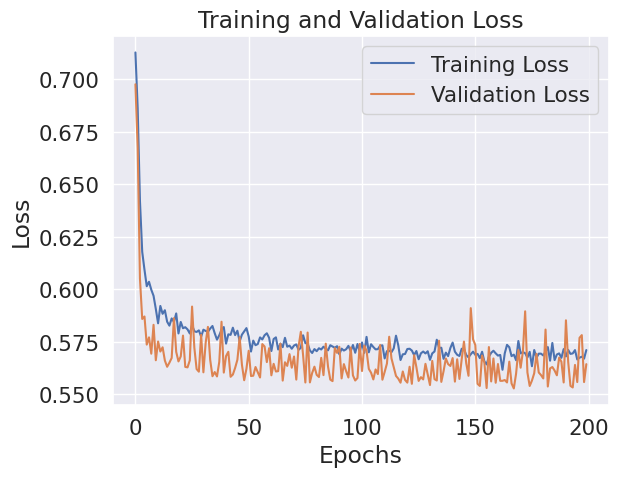

In [54]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

input_shape = (33,)
# Building a simple neural network model
model = models.Sequential([
    layers.Dense(16, input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),# Hidden layer with 128 neurons
    layers.Dense(8),
    layers.LeakyReLU(alpha=0.01),
    layers.Dropout(0.2),                    # Dropout for regularization
    layers.Dense(2, activation='sigmoid')  #
])

# Compile the model with loss function and optimizer
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with training and validation data
history = model.fit(X_train_scaled, y_train, epochs=200, validation_data=(X_valid_scaled, y_valid))

# Plotting Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Submission Stage

In [56]:
df_sub = east_regional_games_csv

In [58]:
columns_drops = [
    "seed_home", "seed_away", "home_away_NS", "rest_days_Home",
    "rest_days_Away", "travel_dist_Home", "travel_dist_Away"
                 ]
df_sub.drop(columns=columns_drops, inplace=True)

In [59]:
df_sub.head()

,game_id,description,team_home,team_away,WINNING %
0,G_East_1,play-in-game,rhode_island_rams,north_carolina_tar_heels,NaN
1,G_East_2,play-in team A v 1,nc_state_wolfpack,rhode_island_rams,NaN
2,G_East_3,play-in team B v 1,nc_state_wolfpack,north_carolina_tar_heels,NaN
3,G_East_4,2 v 15,liberty_flames,bucknell_bison,NaN
4,G_East_5,3 v 14,drexel_dragons,delaware_blue_hens,NaN


KeyError: 'team_home_team1'